In [ ]:
!pip install lightkurve==2.0.11

In [17]:
from google.colab import output

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate,Conv1D, Flatten,Dropout , BatchNormalization, MaxPooling1D

In [ ]:
print(tf.__version__)
pickle.format_version

In [18]:
# ruta de los archivos LightCurveWaveletCollection
dataset_path= '/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/'
# ruta con el archivo csv con las estrllas seleccionadas
df_path = '/content/drive/MyDrive/MASTER IA (Unir)/TFM/light_curves_K_stars_filter.csv'
# punto de divicion entrenamiento y validacion (80%)
train_split = .80

In [19]:
class LightCurveWaveletFoldCollection():
    """
      Clase que contiene las wavelets de las curvas de luz
    """
    def __init__(self,light_curve,wavelets):
        self._light_curve = light_curve
        self._lc_w_collection = wavelets

    def get_detail_coefficent(self,level = None):
        """
        Metodo que devuelve el detalle de los coeficientes de las wavelets
        Parameters
        ----------
        level: int = None
          nivel de profunidad que se desea devolver.
        Returns
        ----------
        retorna una Lista con los valores correspondientes al detalle del coeficiente.
        """
        if level != None:
            return self._lc_w_collection[level-1][1]
        return self._lc_w_collection[:][1]

    def get_approximation_coefficent(self,level = None):
        """
         Metodo que devuelve el coeficiente de aproximacion de las wavelets.
        Parameters
        ----------
        level: int = None
          nivel de profunidad que se desea devolver.
        Returns
        ----------
        retorna una Lista con los valores correspondientes al coeficiente de aproximacion.
        """
        if level != None:
            return self._lc_w_collection[level-1][0]
        return self._lc_w_collection[:][0]
    
    def get_wavelets(self):
        """
         Metodo que devuelve todas las wavelets.
        Parameters
        ----------
        None.
        Returns
        ----------
        retorna una Lista con todos los niveles de descomposicion wavelet.
        """
        return self._lc_w_collection

    def plot(self):
        """
        Metodo imprime la curva de luz y sus descomposiciones.
        Parameters
        ----------
        None.
        Returns
        ----------
        None.
        """
        wavelet = self._lc_w_collection
        time = self._light_curve.time.value
        data = self._light_curve.flux.value
        plt.figure(figsize=(16, 4))
        plt.plot(time,data)
        ig, axarr = plt.subplots(nrows=len(wavelet), ncols=2, figsize=(16,12))
        for i,lc_w in enumerate(wavelet):
            (data, coeff_d) = lc_w
            axarr[i, 0].plot(data, 'r')
            axarr[i, 1].plot(coeff_d, 'g')
            axarr[i, 0].set_ylabel("Level {}".format(i + 1), fontsize=14, rotation=90)
            axarr[i, 0].set_yticklabels([])
            if i == 0:
                axarr[i, 0].set_title("Approximation coefficients", fontsize=14)
                axarr[i, 1].set_title("Detail coefficients", fontsize=14)
            axarr[i, 1].set_yticklabels([])
        plt.show()

class LightCurveWaveletCollection():
    def __init__(self,id,headers,lc_par,lc_inpar):
        self.pliegue_par = lc_par
        self.pliegue_inpar = lc_inpar
        self.kepler_id = id
        self.headers = headers

    def save(self, path = ""):
        """
        Metodo que guarda la curva luz procesada en un archivo.
        Parameters
        ----------
        Path: str = ""
          ruta donde se guardara el archivo.
        Returns
        ----------
        None.
        """
        file_name = path + 'kic '+str(self.kepler_id)+'.pickle'
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    def load(path):
        """
        Metodo que carga la curva luz procesada en un archivo.
        Parameters
        ----------
        Path: str = ""
          ruta donde se encuentra almacenado el archivo.
        Returns
        ----------
        w_loaded: LightCurveWaveletCollection
          Clase que almacena las curvas de luz par e inpar ademas de metadata del proceso de descomposicion.
        """
        with open(path, "rb") as f:
            w_loaded = pickle.load(f)
        return w_loaded

    def plot_comparative(self):
        """
        Metodo que imprime una comparativa entre la curva de luz par e impar..
        Parameters
        ----------
        None.
        Returns
        ----------
        None.
        """
        light_curve_p = self.pliegue_par._light_curve
        light_curve_i = self.pliegue_inpar._light_curve
        w_par_Collection = self.pliegue_par
        w_inpar_Collection = self.pliegue_inpar
        wavelet_p=w_par_Collection.get_wavelets()
        wavelet_i=w_inpar_Collection.get_wavelets()
        plt.figure(figsize=(26, 8))
        plt.plot(light_curve_p.time.value,light_curve_p.flux.value,c='blue',label='par')
        plt.plot(light_curve_i.time.value,light_curve_i.flux.value,c='red',label='inpar')
        
        ig, axarr = plt.subplots(nrows=len(wavelet_p), ncols=2, figsize=(26,26))
        for i,zip_curves in enumerate(zip(wavelet_p,wavelet_i)):
            (data_p, coeff_p),(data_i, coeff_i) = zip_curves
            axarr[i, 0].plot(data_p,c='blue',label='par')
            axarr[i, 0].plot(data_i, c='red',label='inpar')
            axarr[i, 1].plot(coeff_p, c='blue',label='par')
            axarr[i, 1].plot(coeff_i, c='red',label='inpar')
            axarr[i, 0].set_ylabel("Level {}".format(i + 1), fontsize=14, rotation=90)
            axarr[i, 0].set_yticklabels([])
            if i == 0:
                axarr[i, 0].set_title("Approximation coefficients", fontsize=14)
                axarr[i, 1].set_title("Detail coefficients", fontsize=14)
            axarr[i, 1].set_yticklabels([])
        plt.show()


def fold_curve(light_curve_collection, period, epoch, sigma = 20, sigma_upper = 4):
    """
    Toma la coleccion de la curvas entregadas, las pliega y devuelve una sola con todos los datos.
    
    Parameters
    ----------
    light_curve_collection: LightCurveCollection
        coleccion de curvas de luz.
    period: float
        periodo de la orbita.
    epoch: float
        tiempo de cada transcurso.
    sigma: int
        valor de desviaciones estandas
    sigma_upper: int
        valor maximo de variacion
    Returns
    ----------
    una sola curva de luz
    """
    if not is_colab:
        lc_collection = lk.LightCurveCollection([lc.remove_outliers(sigma=20, sigma_upper=4) for lc in light_curve_collection])
    
    lc_ro = lc_collection.stitch()
    
    if is_colab:
        lc_ro = lc_ro.remove_outliers(sigma=sigma, sigma_upper=sigma_upper)
    
    lc_nonans = lc_ro.remove_nans()
    lc_fold = lc_nonans.fold(period = period,epoch_time = epoch)
    lc_odd=lc_fold[lc_fold.odd_mask]
    lc_even = lc_fold[lc_fold.even_mask]
    return lc_fold,lc_odd,lc_even

def apply_wavelet(light_curve,w_family, levels):
    """
    Aplicacion de la wavelet a la curva de luz.
    
    Parameters
    ----------
    light_curve: LightCurve
        curva de luz a la que se le aplica la wavelet.
    w_family: str
        nombre de la familia de wavelet a aplicar.
    levels: int > 0
        niveles de profundida de aplicacion.
    Returns
    ----------
    lc_wavelet: [(numpy.array,numpy.array)]
        Lista con los coeficientes de aproximacion y coeficiente de detalle.
    """
    time = light_curve.time.value
    data = light_curve.flux.value
    lc_wavelet = []
    for level in range(levels):
        level_w = pywt.dwt(data, w_family)
        lc_wavelet.append(level_w)
        data = level_w[0]
    return LightCurveWaveletFoldCollection(light_curve,lc_wavelet)

def load_light_curve(kepler_id,mission='Kepler'):
    """
    Descarga de la curva de luz a patir de la mision y el id.
    Parameters
    ----------
    kepler_id: int
        identificador Kepler.
    mission: str = 'Kepler' 
        mision que obtuvo el regiostro.
    Returns
    ----------
    lc_collection: LightCurveCollection
        Coleccion de curvas de luz.
    """
    kic = 'KIC '+str(kepler_id)
    lc_search = lk.search_lightcurve(kic, mission=mission)
    lc_collection = lc_search.download_all()
    return lc_collection

def cut_wavelet(lightCurve,window):
    
    time = lightCurve.time
    data = lightCurve.flux
    flux_error = lightCurve.flux_err
    index = np.argmin(np.absolute(time))
    min_w = index - int(window/2)
    max_w = index + int(window/2)+1
    time_selected = time[min_w:max_w]
    data_selected = data[min_w:max_w]
    flux_error_selected = flux_error[min_w:max_w]
    return lk.lightcurve.FoldedLightCurve(time=time_selected,flux=data_selected,flux_err=flux_error_selected)
    
def process_light_curve(kepler_id,disp,period,epoch,w_family,levels,plot = False, plot_comparative=False,save=False, path="",wavelet_window=None):
    """
    Metodo que procesa la curva de luz para obtener sus transformadas wavelet.
    Parameters
    ----------
    kepler_id: int
        identificador Kepler.
    period: float
        valor correspondiente al periodo de la curva.   
    epoch: float
        valor correspondiente a la epoca de la curva. 
    w_family: str
        familia de wavelet a aplicar. 
    levels: int
        niveles de profundida para aplicar las wavelets
    plot: boolean = False
        imprime una grafica con los resultados de las wavelets
    plot_comparative: boolean = False
        imprime una grafica comparativa entre las wavelets de los diferentes niveles en curvas pares e inpares.
    save: boolean = False
        genera un archivo guardando la curva de luz y sus descomposiciones wavelets
    path: str
        ruta donde se guardara el archivo en caso de que el parametro save sea True
    wavelet_window: int
        tamaño de la ventana para recortar la curva de luz plegada
    cut_border_percent: float
        porcentaje del total de puntos a recortar del total existente en el nivel de la descomposicion wavelet.
    Returns
    ----------
    lc_wavelet_collection: LightCurveWaveletCollection
        Objeto que contiene la curva de luz y sus wavelets ademas de una cabecera con metadata del proceso.
    """
    # cargamos la curva de segun su Kepler_ID
    print("descargando curvas de luz...")
    lc_collection=load_light_curve(kepler_id)
    # aplicamos el pliege a las curvas de luz y las separamos en pares e inpares
    print('Aplicando pliegue y separando en pares e inpares....') 
    _,lc_inpar,lc_par = fold_curve(lc_collection,period,epoch)

    if not wavelet_window == None:
      print('Aplicando ventana ...')
      lc_inpar = cut_wavelet(lc_inpar,wavelet_window)
      lc_par = cut_wavelet(lc_par,wavelet_window)
    
    print('Aplicando wavelets...')
    # aplicamos wavelets a curvas par
    lc_w_par = apply_wavelet(lc_par,w_family,levels)
    # aplicamos wavelets a curvas inpar
    lc_w_inpar = apply_wavelet(lc_inpar,w_family,levels)
    headers = {
        "period": period,
        "epoch": epoch,
        "class": disp,
        "wavelet_family":w_family,
        "levels":levels,
        "window":wavelet_window
    }
    lc_wavelet_collection = LightCurveWaveletCollection(kepler_id,headers,lc_w_par,lc_w_inpar)
    if(plot):
        print('graficando wavelets obtenidas...')
        lc_w_par.plot()
        lc_w_inpar.plot()
    if(plot_comparative):
        print('graficando wavelets obtenidas...')
        lc_wavelet_collection.plot_comparative()
    if(save):
        print('guardando wavelets obtenidas...')
        lc_wavelet_collection.save(path)
    return lc_wavelet_collection

def process_dataset(df_koi,plot = False, plot_comparative = False,repeat_completed=True,completed=None):
    """
    Metodo que procesa el dataframe de curvas de luz para obtener sus transformadas wavelet.
    Parameters
    ----------
    df_koi: pandas.DataFrame
        Dataset con los datos de las curvas de luz a procesar.
    plot: boolean = False
        Imprime las curvas de luz y sus descomposiciones.
    plot_comparative: boolean = False:
        Imprime una comparativa entre la curva de luz par e impar con sus descomposiciones
    repeat_completed: boolean = True
        Reprocesa las curvas de luz que ya se encuentran procesadas y almacenadas. (Se ocupa para recalcular curvas de procesos anteriores incompletos)
    completed: List = None
        Lista con las curvas de luz completadas de proceso anteriores. 
    Returns
    ----------
    lc_errors: List <int>
        Lista con las curvas de luz que no se pudieron procesar.
    """
    lc_wavelets = dict()
    lc_errors = []
    for i in range (len(df_koi)):

        koi_id,disp, period, epoch=df_koi[['kepid','koi_disposition','koi_period','koi_time0bk']].iloc[i]
        percent = i*100/(len(df_koi))
        print(f'procesando curva de luz KIC {int(koi_id)}[{disp}] [{percent:.0f}%]')
        if not repeat_completed and str(koi_id) in completed:
          print("curva de luz procesada anteriormente")
          continue
        try:
             process_light_curve(int(koi_id),disp,period,epoch,wavelet_family,level,plot= plot,plot_comparative=plot_comparative,save = save_lc, path = save_path,wavelet_window=wavelet_windows)
        except:
            lc_errors.append(koi_id)
            print(f'Error with KIC {koi_id}')
    f = open (save_path+'errors.txt','w')
    for lc_error in lc_errors:
        text = 'KIC '+str(lc_error)+'\n'
        f.write(text)
    f.close()
    return lc_errors
    

In [20]:
def plot_results(history):
    """
    Imprime un grafico con los valores de acurray y loss para entrenamiento y test.
    Parameters
    ----------
    histoy: List
        valores de entrenmiento y perdida obtenidas de la funcion fit.
    Returns
    ----------
    None.
    """
    # GRÁFICO DE LA PRECISIÓN y PERDIDA CON DATOS DE ENTRENAMIENTO
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Presición Entrenamiento')
    plt.plot(epochs, val_acc, 'b', label='Presición Validación')
    plt.title('Presición entrenamiento y test')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

    plt.plot(epochs, loss, 'r',linestyle = 'dashed', label='Pérdida de Entrenamiento')
    plt.plot(epochs, val_loss, 'b',linestyle = 'dashed', label='Perdida de Validación')
    plt.title('Pérdida entrenamiento y test')
    plt.legend(loc=0)
    plt.show()
    
def load_files(path,randomize=True):
    """
    Genera una lista con los archivos existentes de las curvas de luz procesadas.
    Parameters
    ----------
    path: str
      carpeta donde se encuentran almacendas las curvas de luz.
    randomize: boolean = True
        desordena las posiciones del los nombres de curvas de luz cargadas.
    Returns
    ----------
    completed_id: List
      Una lista con los identificadores de los archivos encontrados.
    """
    completed = os.listdir(path)
    if 'errors.txt' in completed:
      completed.remove('errors.txt')
    completed_id = []
    for element in completed:
      completed_id.append(path+element)
    if randomize:
      random.shuffle(completed_id)
    return completed_id

def generate_dataset_model_1(path,level=1):
    """
    Genera el dataset con las curvas de luz cargadas, este metodo solo devuelve 1 nivel de curvas de luz.
    Parameters
    ----------
    path: str
      carpeta donde se encuentran almacendas las curvas de luz.
    level: int = 1
        nivel de profundidad de la descomposicion wavelet a cargar.
    Returns
    ----------
    dataset_par: List
      Lista con las curvas pares
    dataset_inpar: List
      Lista con las curvas impares
    labels: List
      Lista con los Labeles correspondientes a cada curva de luz.
    """
    files = load_files(path)
    dataset_par =[]
    dataset_inpar= []
    labels = []
    len_points = None

    for i,file in enumerate(files):
      output.clear()
      print(f"loading [{i*100/len(files):.0f}%] file:{file}")
      lcwC = LightCurveWaveletCollection.load(file)
      status = lcwC.headers['class']
      curva_par = lcwC.pliegue_par.get_approximation_coefficent(level=level)
      curva_inpar = lcwC.pliegue_inpar.get_approximation_coefficent(level=level)
      #print(i,len(curva_par),len(curva_inpar),['-' for x in range(int(len(curva_par)/10))])
      if len_points == None:
        len_points = len(curva_par)
      if len(curva_par)!= len_points or  len(curva_inpar)!= len_points:
        continue
      dataset_par.append(curva_par)
      #dataset_par=np.append(dataset_par,[curva_par])
      dataset_inpar.append(curva_inpar)
      #dataset_inpar=np.append(dataset_inpar,[curva_inpar])
      labels.append(0 if status == 'FALSE POSITIVE' else 1)
    
    dataset_par = np.array(dataset_par)
    dataset_inpar = np.array(dataset_inpar)
    labels = np.array(labels)
    return dataset_par,dataset_inpar,labels

def generate_dataset_model_2(path,levels=[1],show_loading = True):
    """
    Genera el dataset con las curvas de luz cargadas, este metodo es capas de devolver mas de 1 nivel de curvas de luz.
    Parameters
    ----------
    path: str
      carpeta donde se encuentran almacendas las curvas de luz.
    levels: List = [1]
        nivel de profundidad de la descomposicion wavelet a cargar.
    show_loading: boolean = True
      Muestra el porcentaje de carga de las curvas de luz.
    Returns
    ----------
    dataset_par: List
      Lista con las curvas pares
    dataset_inpar: List
      Lista con las curvas impares
    labels: List
      Lista con los Labeles correspondientes a cada curva de luz.
    """
    files = load_files(path)
    #print(f"file len:{len(files)}")
    labels = []
    len_points = {}
    curvas = {}

    for level in levels:
      curvas["par_"+str(level)] = []
      curvas["impar_"+str(level)] = []
      len_points[str(level)]=None

    for i,file in enumerate(files):
      skip_label = False
      if show_loading:
        print(f"loading [{i*100/len(files):.0f}%] file:{file}")
      lcwC = LightCurveWaveletCollection.load(file)
      status = lcwC.headers['class']

      for level in levels:
        curva_par = lcwC.pliegue_par.get_approximation_coefficent(level=level)
        curva_inpar = lcwC.pliegue_inpar.get_approximation_coefficent(level=level)

        if len_points[str(level)] == None:
          len_points[str(level)] = len(curva_par)
        if len(curva_par)!= len_points[str(level)] or  len(curva_inpar)!= len_points[str(level)]:
          skip_label = True
          break
        curvas["par_"+str(level)].append(curva_par)
        curvas["impar_"+str(level)].append(curva_inpar)

      if not skip_label:
        labels.append(0 if status == 'FALSE POSITIVE' else 1)
    #dataset_par = np.array(dataset_par)
    #dataset_inpar = np.array(dataset_inpar)
    for level in levels:
      curvas["par_"+str(level)] = np.array(curvas["par_"+str(level)])
      curvas["impar_"+str(level)] = np.array(curvas["impar_"+str(level)])
    labels = np.array(labels)
    #print("len curvas",len(curvas["par_"+str(levels[0])]),  " len labels", len(labels) )
    return curvas,labels


def split_dataset(dataset_p, dataset_i, labels, split=.80):
    """
    Metodo que divide el dataset en entrenamiento y test.
    Parameters
    ----------
    dataset_p: List
      Lista con las wavelets pares.
    dataset_i: List 
      Lista con las wavelets impares.
    labels: List
      Etiquetas de la wavelet correspondientes.
    split: float = .80
      porcentaje de registros donde se realizara el corte correspondientes a entrenamiento y test
    Returns
      List_1: List [List,List]
        lista con las curvas pares e impares para entrenamiento 
      List_2: List [List,List]
        lista con las curvas pares e impares para test
      y_train: List [0|1]
        Lista con las etiquetas de las curvas de entrenamiento
      y_test: List [0|1]
        Lista con las etiquetas de las curvas de test
    ----------
    dataset_par: List
      Lista con las curvas pares
    dataset_inpar: List
      Lista con las curvas impares
    labels: List
      Lista con los Labeles correspondientes a cada curva de luz.
    """
    split = int(len(labels)*split)
    print(f"before par:{np.shape(dataset_p)} impar:{np.shape(dataset_i)}, labels:{len(labels)}")
    X_p_train = dataset_p[:split]
    X_i_train = dataset_i[:split]
    y_train = labels[:split]

    X_p_test = dataset_p[split:]
    X_i_test = dataset_i[split:]
    y_test = labels[split:]

    X_p_train = np.expand_dims(X_p_train, axis=-1)
    X_i_train = np.expand_dims(X_i_train, axis=-1)
    X_p_test = np.expand_dims(X_p_test, axis=-1)
    X_i_test = np.expand_dims(X_i_test, axis=-1)
    print(f"par:{np.shape(X_p_test)} impar:{np.shape(X_i_test)}, labels:{len(y_test)}")
    return [X_p_train, X_i_train], [X_p_test, X_i_test], y_train, y_test

def normalize_data(data):
    """
    Metodo que normaliza los datos de una lista.
    Parameters
    ----------
    data: List
      lista con los valores de la curva par o impar.
    Returns
    ----------
    value: List
      lista con los valores normalizados entre 0 y 1
    """
    min = np.min(data)
    max = np.max(data)
    return (data - min)/(max-min) 

def normalize_data_2(data_p,data_i):
    """
    Metodo que normaliza los datos de 2 lista en conjunto.
    Parameters
    ----------
    data_p: List
      lista con los valores de la curva par
    data_p: List
      lista con los valores de la curva impar 
    Returns
    ----------
    list_1: List
      lista con los valores normalizados entre 0 y 1 de la wavelet par
    list_2: List
      lista con los valores normalizados entre 0 y 1 de la wavelet impar
    """
    min = np.min(data_p) if np.min(data_p) < np.min(data_i) else np.min(data_i)
    max = np.max(data_p) if np.max(data_p) > np.max(data_i) else np.max(data_i)
    return [(data_p - min)/(max-min) , (data_i - min)/(max-min)]

def normalize_LC(curvas_dic):
    """
    Metodo que aplica la normalizacion a multiples niveles de descomposicion wavelet.
    Parameters
    ----------
    curvas_dic: List
      diccionario que contiene los distintos niveles de curvas.
    Returns
    ----------
    list: List [List[List],List[list]] => List[wavelt_par[registros],wavelet_impar[registros]]
      lista con los valores normalizados entre 0 y 1 de todos los niveles de wavelet
    """
    #return [ [normalize_data(curvas_dic[ list(curvas_dic.keys())[i]]),normalize_data(curvas_dic[ list(curvas_dic.keys())[i+1]]) ] for i in range(0,len(curvas_dic.keys()),2)   ] 
    return [ normalize_data_2(curvas_dic[ list(curvas_dic.keys())[i]],curvas_dic[ list(curvas_dic.keys())[i+1]])  for i in range(0,len(curvas_dic.keys()),2)   ] 

def split_data_list(list_data,labels):
    """
      Metodo que divide en entrenamiento y test los registros de mas de una curva wavelet.
      Parameters
      ----------
      list_data: List
        Lista que contiene los distintos niveles de curvas.
      labels: List
        Lista que contiene las etiquetas correspondientes a las descomposiciones wavelet.
      Returns
      ----------
      ds_train: List
        Lista con los registros para entrenamiento
      ds_test: List
        Lista con los registros para validacion
      label_train: List
        Lista con las etiquetas para entrenamiento
      label_test: List
        Lista con las etiquetas para validacion
      """
    ds_train = []
    ds_test = []
    label_train = []
    label_test = []
    first = True
    for c_par, c_impar in list_data:
      X_train, X_test, y_train, y_test = split_dataset(c_par, c_impar,labels)
      ds_train.append(X_train)
      ds_test.append(X_test)
      if first :
        label_train = y_train
        label_test = y_test
        first = False

    return ds_train,ds_test,label_train,label_test

def evaluate_model(model,dataset,verbose = 0,epochs=1000):
    """
    Metodo que evalua un modelo de multiple niveles de descomposicion wavelet y muestra los resultados de entrenamiento y validacion.
    Parameters
    ----------
    model: def
      nombre de la funcion generadora del modelo a probar.
    dataset: str
      path con la ubicacion de las LightCurveWaveletCollection.
    Verbose: int = 0
      nivel de informacion del entrenamiento, mas informacion en la web de Keras.
    epochs: int = 1000
      cantidad de epocas de entrenamiento.
    Returns
    ----------
    None.
    """
    # Modelado Dataset
    print('normalizando datos...')
    ds_levels = normalize_LC(dataset[0])
    print('dividiendo datos en entrenamioento y test...')
    ds_train,ds_test,label_train,label_test = split_data_list(ds_levels,dataset[1])
    # entrenamiento
    print('generando modelo...')
    model_g = model(ds_train,activation = tf.keras.layers.LeakyReLU())
    print('compilando modelo....')
    model_g.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy','binary_crossentropy'])
    print('entrenando....')
    #early_stopping_acc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0005, patience=30, mode='max', verbose = 1)#EarlyStopping(monitor='accuracy', patience=15, min_delta=0.005, mode='max')
    early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, patience=15, mode='min', verbose = 1)
    history = model_g.fit(ds_train, label_train, epochs=epochs, batch_size=64,validation_split=0.20,shuffle=True,verbose=verbose, callbacks=[early_stopping_loss])
    print('obteniendo resultados..')
    plot_results(history)
    result = model_g.evaluate(ds_test, label_test)
    print(result)
    del model_g, history, result, ds_train,ds_test,label_train, label_test, ds_levels
  
def evaluate_model_1_level(model,dataset,level,verbose = 0 ,epochs=1000):
    """
    Metodo que evalua un modelo de un solo nivel de descomposicion wavelet y muestra los resultados de entrenamiento y validacion.
    Parameters
    ----------
    model: def
      nombre de la funcion generadora del modelo a probar.
    dataset: str
      path con la ubicacion de las LightCurveWaveletCollection.
    level: int
      niveles de wavelet a evaluar.
    Verbose: int = 0
      nivel de informacion del entrenamiento, mas informacion en la web de Keras.
    epochs: int = 1000
      cantidad de epocas de entrenamiento.
    Returns
    ----------
    None.
    """
    print('Cargando dataset...')
    ds_p,ds_i,label = generate_dataset_model_1(dataset_path,level)
    print('normalizando datos...')
    ds = normalize_data_2(ds_p,ds_i)
    print('dividiendo dataset...')
    X_train, X_test, y_train, y_test = split_dataset(ds[0], ds[1], label)
    print('generando modelo....')
    model_g = model(X_train,activation = tf.keras.layers.LeakyReLU())
    model_g.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    print('entrenando...')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.005, mode='max')
    #early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, patience=15, mode='min', verbose = 1)
    history_2 = model_g.fit(X_train, y_train, epochs=epochs, batch_size=64,validation_split=0.20,shuffle=True,verbose = verbose, callbacks=[early_stopping])
    print('Resultados...')
    plot_results(history_2)
    _, accuracy = model_g.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))

    y_prediction =[0 if x <= 0.5 else 1 for x in model_g.predict(X_test) ]
    result = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=result)
    disp.plot()
    plt.show()
    del  X_train, X_test, y_train, y_test, ds_p, ds_i, ds, label, model_g, history_2, accuracy
    

# Construnccion del modelo 1
    [Conv1D(16,5)]    [Conv1D(16,5)]
    [Conv1D(16,5)]    [Conv1D(16,5)]
    [MaxPool(3,2)]    [MaxPool(3,2)]
    [Conv1D(32,5)]    [Conv1D(32,5)]
    [Conv1D(32,5)]    [Conv1D(32,5)]
    [MaxPool(3,2)]    [MaxPool(3,2)]
      [Flatten()]      [Flatten()]
                [Concat]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(1sigmoid)]





In [8]:
def gen_model_1_level(ds,activation = 'relu'): 
  input_shape = np.shape(ds)[2:]
  print(input_shape)
  model_p = tf.keras.Sequential()
  model_p.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=input_shape))
  model_p.add(Conv1D(filters=16, kernel_size=5, activation='relu')) 
  model_p.add(MaxPooling1D(pool_size=3, strides=1)) 
  model_p.add(Conv1D(32,5, activation='relu'))
  model_p.add(Conv1D(32,5, activation='relu'))
  model_p.add(MaxPooling1D(pool_size=3, strides=1))
  model_p.add(Flatten())

  model_i = tf.keras.Sequential()
  model_i.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=input_shape))
  model_i.add(Conv1D(filters=16, kernel_size=5, activation='relu')) 
  model_i.add(MaxPooling1D(pool_size=3, strides=1)) 
  model_i.add(Conv1D(32,5, activation='relu'))
  model_i.add(Conv1D(32,5, activation='relu'))
  model_i.add(MaxPooling1D(pool_size=3, strides=1))
  model_i.add(Flatten())

  model_f = concatenate([model_p.output,model_i.output], axis=-1)
  model_f = Dense(512,activation='relu')(model_f)
  model_f = Dense(512,activation='relu')(model_f)
  model_f = Dense(512,activation='relu')(model_f)
  model_f = Dense(512,activation='relu')(model_f)
  model_f = Dense(1,activation='sigmoid')(model_f)
  model_f = Model([model_p.input,model_i.input],model_f)
  return model_f

# Construnccion del modelo 1 nivel con 1 seccion convolucional mas
    [Conv1D(16,5)]    [Conv1D(16,5)]
    [Conv1D(16,5)]    [Conv1D(16,5)]
    [MaxPool(3,2)]    [MaxPool(3,2)]
    [Conv1D(32,5)]    [Conv1D(32,5)]
    [Conv1D(32,5)]    [Conv1D(32,5)]
    [MaxPool(3,2)]    [MaxPool(3,2)]
    [Conv1D(64,5)]    [Conv1D(64,5)]
    [Conv1D(64,5)]    [Conv1D(64,5)]
    [MaxPool(3,2)]    [MaxPool(3,2)]
      [Flatten()]      [Flatten()]
                [Concat]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(512relu)]
            [Dense(1sigmoid)]





In [21]:
def gen_model_1_level_2(ds,activation = 'relu'): 
  input_shape = np.shape(ds)[2:]
  model_p = tf.keras.Sequential()
  model_p.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
  model_p.add(Conv1D(filters=32, kernel_size=5, )) 
  model_p.add(MaxPooling1D(pool_size=3, strides=1)) 
  model_p.add(Conv1D(64,5))
  model_p.add(Conv1D(64,5))
  model_p.add(MaxPooling1D(pool_size=3, strides=1))
  model_p.add(Conv1D(128,5))
  model_p.add(Conv1D(128,5))
  model_p.add(MaxPooling1D(pool_size=3, strides=1))
  model_p.add(Flatten())

  model_i = tf.keras.Sequential()
  model_i.add(Conv1D(filters=32, kernel_size=5,  input_shape=input_shape))
  model_i.add(Conv1D(filters=32, kernel_size=5,)) 
  model_i.add(MaxPooling1D(pool_size=3, strides=1)) 
  model_i.add(Conv1D(64,5))
  model_i.add(Conv1D(64,5))
  model_i.add(MaxPooling1D(pool_size=3, strides=1))
  model_i.add(Conv1D(128,5))
  model_i.add(Conv1D(128,5))
  model_i.add(MaxPooling1D(pool_size=3, strides=1))
  model_i.add(Flatten())

  model_f = concatenate([model_p.output,model_i.output], axis=-1)
  model_f = BatchNormalization(axis=-1)(model_f)
  model_f = Dense(256,activation='relu')(model_f)
  model_f = Dense(256,activation='relu')(model_f)
  model_f = Dropout(.2)(model_f)
  model_f = Dense(256,activation='relu')(model_f)
  model_f = Dense(256,activation='relu')(model_f)
  model_f = Dropout(.2)(model_f)
  model_f = Dense(256,activation='relu')(model_f)
  model_f = Dense(1,activation='sigmoid')(model_f)
  model_f_2 = Model(inputs=[model_p.input,model_i.input],outputs=model_f)
  return model_f_2

# Construnccion del modelo 2 niveles

    [Conv1D(16,5)]                                        [Conv1D(16,5)]
    [Conv1D(16,5)]                                        [Conv1D(16,5)]
    [MaxPool(3,1)]                                        [MaxPool(3,1)]
    [Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]
    [Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]
    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]
    [Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]
    [Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]
    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]
    [Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]
    [Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]
    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]
      [Flatten()]      [Flatten()]        [Flatten()]      [Flatten()]
                                  [Concat]
                              [Dense(512relu)]
                              [Dense(512relu)]
                              [Dense(512relu)]
                              [Dense(512relu)]
                              [Dense(1sigmoid)]

In [ ]:
def gen_model_2_levels(ds,activation = 'relu',summary=False):
    # tamaño nivel 7
    input_shape_1 = np.shape(ds[0])[2:]
    # tamaño nivel 8
    input_shape_2 = np.shape(ds[1])[2:]
   
    # rama par level 7
    model_p_7 = tf.keras.Sequential()
    model_p_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_1))
    model_p_7.add(Conv1D(16, 5, activation=activation)) 
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Flatten())
    
    # rama par level 8
    model_p_8 = tf.keras.Sequential()
    model_p_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_2))
    model_p_8.add(Conv1D(16, 5, activation=activation)) 
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Flatten())
    
    # rama impar level 7
    model_i_7 = tf.keras.Sequential()
    model_i_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_1))
    model_i_7.add(Conv1D(16, 5, activation=activation)) 
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Flatten())
    
    # rama impar level 8
    model_i_8 = tf.keras.Sequential()
    model_i_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_2))
    model_i_8.add(Conv1D(16, 5, activation=activation)) 
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Flatten())

    # Red profunda
    model_f = concatenate([model_p_7.output,model_i_7.output,
                           model_p_8.output,model_i_8.output], axis=-1)
    model_f = BatchNormalization(axis=-1)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(1,activation='sigmoid')(model_f)
    model_f = Model([[model_p_7.input,model_i_7.input],[model_p_8.input,model_i_8.input]],model_f)
    if summary:
      model_f.summary()
    return model_f

In [ ]:
model_3 =  gen_model_3()
model_3.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','binary_crossentropy'])
history_2 = model_3.fit([X_train_7,X_train_8], y_train_7, epochs=1000, batch_size=64,validation_split=0.15,shuffle=True)
plot_results(history_2)

NameError: ignored

# Construnccion del modelo 3 niveles

		[Conv1D(16,5)]				                                          					[Conv1D(16,5)]
		[Conv1D(16,5)]					                                        				[Conv1D(16,5)]
		[MaxPool(3,1)]					                                        				[MaxPool(3,1)]
		[Conv1D(32,5)]	[Conv1D(16,5)]                                        [Conv1D(16,5)]	[Conv1D(32,5)]
		[Conv1D(32,5)]	[Conv1D(16,5)]                                        [Conv1D(16,5)]	[Conv1D(32,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]                                        [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(64,5)]	[Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]	[Conv1D(64,5)]
		[Conv1D(64,5)]	[Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]	[Conv1D(64,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(128,5)]	[Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]	[Conv1D(128,5)]
		[Conv1D(12u,5)]	[Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]	[Conv1D(128,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(256,5)]	[Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]	[Conv1D(256,5)]
		[Conv1D(256,5)]	[Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]	[Conv1D(256,5)]
		[MaxPool(3,1)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(16,5)]
		 [Flatten()]	  [Flatten()]      [Flatten()]        [Flatten()]      [Flatten()]		[Flatten()]
                                                        [Concat]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(1sigmoid)]

In [ ]:
def gen_model_3_levels(ds,activation = 'relu', print_summary = False):
    # tamaño nivel 3
    input_shape_3 = np.shape(ds[0])[2:]
    # tamaño nivel 7
    input_shape_7 = np.shape(ds[1])[2:]
    # tamaño nivel 8
    input_shape_8 = np.shape(ds[2])[2:]
   
     # rama par level 3
    model_p_3 = tf.keras.Sequential()
    model_p_3.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_3))
    model_p_3.add(Conv1D(16, 5, activation=activation)) 
    model_p_3.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_3.add(Conv1D(32,5, activation=activation))
    model_p_3.add(Conv1D(32,5, activation=activation))
    model_p_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_3.add(Conv1D(64,5, activation=activation))
    model_p_3.add(Conv1D(64,5, activation=activation))
    model_p_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_3.add(Conv1D(128,5, activation=activation))
    model_p_3.add(Conv1D(128,5, activation=activation))
    model_p_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_3.add(Conv1D(128,5, activation=activation))
    model_p_3.add(Conv1D(128,5, activation=activation))
    model_p_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_3.add(Flatten())

    # rama par level 7
    model_p_7 = tf.keras.Sequential()
    model_p_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_7))
    model_p_7.add(Conv1D(16, 5, activation=activation)) 
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Flatten())
    
    # rama par level 8
    model_p_8 = tf.keras.Sequential()
    model_p_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_8))
    model_p_8.add(Conv1D(16, 5, activation=activation)) 
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Flatten())
    
     # rama impar level 3
    model_i_3 = tf.keras.Sequential()
    model_i_3.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_3))
    model_i_3.add(Conv1D(16, 5, activation=activation)) 
    model_i_3.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_3.add(Conv1D(32,5, activation=activation))
    model_i_3.add(Conv1D(32,5, activation=activation))
    model_i_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_3.add(Conv1D(64,5, activation=activation))
    model_i_3.add(Conv1D(64,5, activation=activation))
    model_i_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_3.add(Conv1D(128,5, activation=activation))
    model_i_3.add(Conv1D(128,5, activation=activation))
    model_i_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_3.add(Conv1D(128,5, activation=activation))
    model_i_3.add(Conv1D(128,5, activation=activation))
    model_i_3.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_3.add(Flatten())

    # rama impar level 7
    model_i_7 = tf.keras.Sequential()
    model_i_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_7))
    model_i_7.add(Conv1D(16, 5, activation=activation)) 
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Flatten())
    
    # rama impar level 8
    model_i_8 = tf.keras.Sequential()
    model_i_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_8))
    model_i_8.add(Conv1D(16, 5, activation=activation)) 
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Flatten())

    # Red profunda
    model_f = concatenate([model_p_3.output,model_i_3.output,
                           model_p_7.output,model_i_7.output,
                           model_p_8.output,model_i_8.output], axis=-1)
    
    model_f = BatchNormalization(axis=-1)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dropout(0.2)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dropout(0.2)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(1,activation='sigmoid')(model_f)
    model_f = Model([[model_p_3.input,model_i_3.input],[model_p_7.input,model_i_7.input],[model_p_8.input,model_i_8.input]],model_f)
    if print_summary:
      model_f.summary()
    return model_f

In [ ]:
model_4 =  gen_model_3_levels(ds_3_train,activation = tf.keras.layers.LeakyReLU())
model_4.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy','binary_crossentropy'])
history_4 = model_4.fit(ds_3_train, label_3_train, epochs=1000, batch_size=64,validation_split=0.15,shuffle=True)
plot_results(history_4)

# Construnccion modelo de 4 niveles

		[Conv1D(16,5)]				                                          					[Conv1D(16,5)]
		[Conv1D(16,5)]					                                        				[Conv1D(16,5)]
		[MaxPool(3,1)]					                                        				[MaxPool(3,1)]
		[Conv1D(32,5)]	[Conv1D(16,5)]                                        [Conv1D(16,5)]	[Conv1D(32,5)]
		[Conv1D(32,5)]	[Conv1D(16,5)]                                        [Conv1D(16,5)]	[Conv1D(32,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]                                        [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(64,5)]	[Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]	[Conv1D(64,5)]
		[Conv1D(64,5)]	[Conv1D(32,5)]    [Conv1D(16,5)]    [Conv1D(16,5)]    [Conv1D(32,5)]	[Conv1D(64,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(128,5)]	[Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]	[Conv1D(128,5)]
		[Conv1D(12u,5)]	[Conv1D(64,5)]    [Conv1D(32,5)]    [Conv1D(32,5)]    [Conv1D(64,5)]	[Conv1D(128,5)]
		[MaxPool(3,5)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(3,1)]
		[Conv1D(256,5)]	[Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]	[Conv1D(256,5)]
		[Conv1D(256,5)]	[Conv1D(128,5)]   [Conv1D(64,5)]    [Conv1D(64,5)]    [Conv1D(128,5)]	[Conv1D(256,5)]
		[MaxPool(3,1)]	[MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]    [MaxPool(3,1)]	[MaxPool(16,5)]
		 [Flatten()]	  [Flatten()]      [Flatten()]        [Flatten()]      [Flatten()]		[Flatten()]
                                                        [Concat]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(512relu)]
                                                      [Dense(1sigmoid)]

In [ ]:
def gen_model_4_levels(ds_train,activation = 'relu'):
    # tamaño nivel 5
    input_shape_5 = np.shape(ds_train[0])[2:]
    # tamaño nivel 6
    input_shape_6 = np.shape(ds_train[1])[2:]
    # tamaño nivel 7
    input_shape_7 = np.shape(ds_train[2])[2:]
    # tamaño nivel 8
    input_shape_8 = np.shape(ds_train[3])[2:]

     # rama par level 5
    model_p_5 = tf.keras.Sequential()
    model_p_5.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_5))
    model_p_5.add(Conv1D(16, 5, activation=activation)) 
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_5.add(Conv1D(32,5, activation=activation))
    model_p_5.add(Conv1D(32,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Conv1D(64,5, activation=activation))
    model_p_5.add(Conv1D(64,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Conv1D(128,5, activation=activation))
    model_p_5.add(Conv1D(128,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Conv1D(128,5, activation=activation))
    model_p_5.add(Conv1D(128,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Conv1D(256,5, activation=activation))
    model_p_5.add(Conv1D(256,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Conv1D(256,5, activation=activation))
    model_p_5.add(Conv1D(256,5, activation=activation))
    model_p_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_5.add(Flatten())

    # rama par level 6
    model_p_6 = tf.keras.Sequential()
    model_p_6.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_6))
    model_p_6.add(Conv1D(16, 5, activation=activation)) 
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_6.add(Conv1D(32,5, activation=activation))
    model_p_6.add(Conv1D(32,5, activation=activation))
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_6.add(Conv1D(64,5, activation=activation))
    model_p_6.add(Conv1D(64,5, activation=activation))
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_6.add(Conv1D(128,5, activation=activation))
    model_p_6.add(Conv1D(128,5, activation=activation))
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_6.add(Conv1D(128,5, activation=activation))
    model_p_6.add(Conv1D(128,5, activation=activation))
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_6.add(Conv1D(256,5, activation=activation))
    model_p_6.add(Conv1D(256,5, activation=activation))
    model_p_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_6.add(Flatten())

    # rama par level 7
    model_p_7 = tf.keras.Sequential()
    model_p_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_7))
    model_p_7.add(Conv1D(16, 5, activation=activation)) 
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(Conv1D(32,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(Conv1D(64,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(Conv1D(128,5, activation=activation))
    model_p_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_7.add(Flatten())
    
    # rama par level 8
    model_p_8 = tf.keras.Sequential()
    model_p_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_8))
    model_p_8.add(Conv1D(16, 5, activation=activation)) 
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(Conv1D(32,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(Conv1D(64,5, activation=activation))
    model_p_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_p_8.add(Flatten())
    
     # rama impar level 5
    model_i_5 = tf.keras.Sequential()
    model_i_5.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_5))
    model_i_5.add(Conv1D(16, 5, activation=activation)) 
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_5.add(Conv1D(32,5, activation=activation))
    model_i_5.add(Conv1D(32,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Conv1D(64,5, activation=activation))
    model_i_5.add(Conv1D(64,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Conv1D(128,5, activation=activation))
    model_i_5.add(Conv1D(128,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Conv1D(128,5, activation=activation))
    model_i_5.add(Conv1D(128,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Conv1D(256,5, activation=activation))
    model_i_5.add(Conv1D(256,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Conv1D(256,5, activation=activation))
    model_i_5.add(Conv1D(256,5, activation=activation))
    model_i_5.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_5.add(Flatten())

    # rama impar level 6
    model_i_6 = tf.keras.Sequential()
    model_i_6.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_6))
    model_i_6.add(Conv1D(16, 5, activation=activation)) 
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_6.add(Conv1D(32,5, activation=activation))
    model_i_6.add(Conv1D(32,5, activation=activation))
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_6.add(Conv1D(64,5, activation=activation))
    model_i_6.add(Conv1D(64,5, activation=activation))
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_6.add(Conv1D(128,5, activation=activation))
    model_i_6.add(Conv1D(128,5, activation=activation))
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_6.add(Conv1D(128,5, activation=activation))
    model_i_6.add(Conv1D(128,5, activation=activation))
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_6.add(Conv1D(256,5, activation=activation))
    model_i_6.add(Conv1D(256,5, activation=activation))
    model_i_6.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_6.add(Flatten())

    # rama impar level 7
    model_i_7 = tf.keras.Sequential()
    model_i_7.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_7))
    model_i_7.add(Conv1D(16, 5, activation=activation)) 
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(Conv1D(32,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(Conv1D(64,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(Conv1D(128,5, activation=activation))
    model_i_7.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_7.add(Flatten())
    
    # rama impar level 8
    model_i_8 = tf.keras.Sequential()
    model_i_8.add(Conv1D(16, 5, activation=activation, input_shape=input_shape_8))
    model_i_8.add(Conv1D(16, 5, activation=activation)) 
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1)) 
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(Conv1D(32,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(Conv1D(64,5, activation=activation))
    model_i_8.add(MaxPooling1D(pool_size=3, strides=1))
    model_i_8.add(Flatten())

    # Red profunda
    model_f = concatenate([model_p_5.output,model_i_5.output,
                           model_p_6.output,model_i_6.output,
                           model_p_7.output,model_i_7.output,
                           model_p_8.output,model_i_8.output], axis=-1)
    model_f = Dense(1012,activation=activation)(model_f)
    model_f = Dense(750,activation=activation)(model_f)
    model_f = Dropout(0.2)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dropout(0.2)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(512,activation=activation)(model_f)
    model_f = Dense(1,activation='sigmoid')(model_f)
    model_f = Model([[model_p_5.input,model_i_5.input],[model_p_6.input,model_i_6.input],[model_p_7.input,model_i_7.input],[model_p_8.input,model_i_8.input]],model_f)
    model_f.summary()
    return model_f

In [ ]:
model_5 =  gen_model_5(ds_4_train, activation = tf.keras.layers.LeakyReLU())
model_5.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy','binary_crossentropy'])
history_5 = model_5.fit(ds_4_train, label_4_train, epochs=1000, batch_size=64,validation_split=0.15,shuffle=True)
plot_results(history_5)

# Modelo de prueba de conv1D

In [ ]:
model = tf.keras.Sequential()
model.add(Conv1D(filters=16, kernel_size=5, activation='sigmoid', input_shape=(59, 1)))
model.add(Conv1D(filters=16, kernel_size=5, activation='sigmoid')) 
model.add(MaxPooling1D(pool_size=3, strides=2)) # change to 2 or add `padding="same"` to the conv layers
model.add(Conv1D(32,5, activation='sigmoid'))
model.add(Conv1D(32,5, activation='sigmoid'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_test = model.fit(X_train_8[0], y_train_8, epochs=50, batch_size=32,validation_split=0.3,shuffle=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 55, 16)            96        
                                                                 
 conv1d_21 (Conv1D)          (None, 51, 16)            1296      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 21, 32)            2592      
                                                                 
 conv1d_23 (Conv1D)          (None, 17, 32)            5152      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                 

ValueError: ignored

In [ ]:
plot_results(hist_test)

In [ ]:
_, accuracy = model.evaluate(X_test[0], y_test)
print('Accuracy: %.2f' % (accuracy*100))

# Pruebas


## Curvas de luz solas

In [13]:
def generate_dataset_lc(path,reduce_point = None):
  files = load_files(path)
  lc_dateset_par = []
  lc_dateset_impar = []
  lc_labels = []
  len_lc_par = None
  len_lc_impar = None
  is_first = True
  for i in files:
    lc = LightCurveWaveletCollection.load(i)
    lc_class = lc.headers['class']
    lc_par = lc.pliegue_par._light_curve.flux.value
    lc_impar = lc.pliegue_inpar._light_curve.flux.value
    if reduce_point != None:  
      lc_par = lc_par[reduce_point:(len(lc_par)-reduce_point)] 
      lc_impar = lc_impar[reduce_point:(len(lc_impar)-reduce_point)]
    if is_first:
      is_first = False
      len_lc_par = len(lc_par)
    len_lc_impar = len(lc_impar)
    if len(lc_par) == len_lc_par and len(lc_impar) == len_lc_impar:
      lc_dateset_par.append(lc_par)
      lc_dateset_impar.append(lc_impar)
      lc_labels.append(1 if lc_class =='CONFIRMED' else 0)
  dataset_par = np.array(lc_dateset_par)
  dataset_inpar = np.array(lc_dateset_impar)
  lc_labels = np.array(lc_labels)
  return [lc_dateset_par,lc_dateset_impar],lc_labels

def normalize_lc_lc(dataset):
  ds_norm_p = []
  ds_norm_i = []
  for lc_p, lc_i in zip(dataset[0],dataset[1]):
    lc_p_n, lc_i_n = normalize_data_2(lc_p,lc_i)
    ds_norm_p.append(lc_p_n)
    ds_norm_i.append(lc_i_n)
  return [ds_norm_p,ds_norm_i]
lc_dateset,lc_labels = generate_dataset_lc(dataset_path,reduce_point=4000)
lc_dateset_norm = normalize_lc_lc(lc_dateset)


In [14]:
display(np.shape(lc_dateset))
display(np.shape(lc_dateset_norm))
ds_lc_train,ds_lc_test,label_lc_train,label_lc_test = split_dataset(lc_dateset_norm[0], lc_dateset_norm[1],lc_labels)
display(np.shape(ds_lc_train))


(2, 526, 7001)

(2, 526, 7001)

before par:(526, 7001) impar:(526, 7001), labels:526
par:(106, 7001, 1) impar:(106, 7001, 1), labels:106


(2, 420, 7001, 1)

In [11]:
type(label_lc_train[0])

numpy.int64

(7001, 1)
entrenando...
Epoch 1/1000
6/6 - 23s - loss: 0.6768 - accuracy: 0.6022 - val_loss: 0.6780 - val_accuracy: 0.5873 - 23s/epoch - 4s/step
Epoch 2/1000
6/6 - 20s - loss: 0.6606 - accuracy: 0.6555 - val_loss: 0.7140 - val_accuracy: 0.5873 - 20s/epoch - 3s/step
Epoch 3/1000
6/6 - 20s - loss: 0.6417 - accuracy: 0.6555 - val_loss: 0.6800 - val_accuracy: 0.5873 - 20s/epoch - 3s/step
Epoch 4/1000
6/6 - 20s - loss: 0.6361 - accuracy: 0.6555 - val_loss: 0.6802 - val_accuracy: 0.5873 - 20s/epoch - 3s/step
Epoch 5/1000
6/6 - 20s - loss: 0.6200 - accuracy: 0.6611 - val_loss: 0.6933 - val_accuracy: 0.6032 - 20s/epoch - 3s/step
Epoch 6/1000
6/6 - 20s - loss: 0.6032 - accuracy: 0.6695 - val_loss: 0.6957 - val_accuracy: 0.5873 - 20s/epoch - 3s/step
Epoch 7/1000
6/6 - 20s - loss: 0.6251 - accuracy: 0.6639 - val_loss: 0.6895 - val_accuracy: 0.5873 - 20s/epoch - 3s/step
Epoch 8/1000
6/6 - 20s - loss: 0.6267 - accuracy: 0.6667 - val_loss: 0.7573 - val_accuracy: 0.6032 - 20s/epoch - 3s/step
Epoch 9/

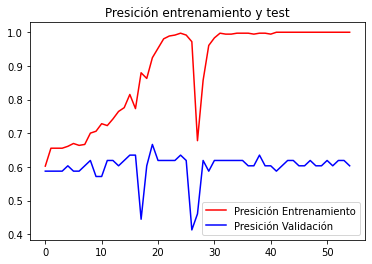

<Figure size 432x288 with 0 Axes>

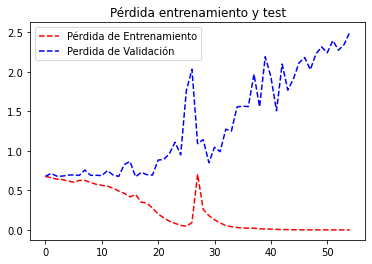

4/4 [==============================] - 2s 357ms/step - loss: 1.8256 - accuracy: 0.6509
Accuracy: 65.09
4/4 [==============================] - 2s 357ms/step


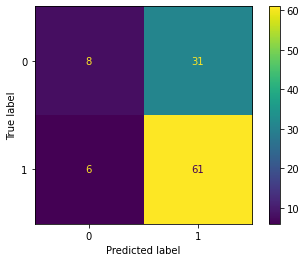

In [16]:
model_lc = gen_model_1_level(ds_lc_train,activation = tf.keras.layers.LeakyReLU())
model_lc.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
print('entrenando...')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=30, min_delta=0.005, mode='max')

history_2 = model_lc.fit(ds_lc_train, label_lc_train, epochs=1000, batch_size=64,validation_split=0.15,shuffle=True,verbose = 2, callbacks=[early_stopping])
print('Resultados...')
plot_results(history_2)
_, accuracy = model_lc.evaluate(ds_lc_test, label_lc_test)
print('Accuracy: %.2f' % (accuracy*100))

y_prediction =[0 if x <= 0.5 else 1 for x in model_lc.predict(ds_lc_test) ]
result = confusion_matrix(label_lc_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
plt.show()

## 1 nivel

In [ ]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,2,verbose=2)

loading [100%] file:/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/kic 10405224-K08008.01.pickle
normalizando datos...
dividiendo dataset...
before par:(526, 3007) impar:(526, 3007), labels:526
par:(106, 3007, 1) impar:(106, 3007, 1), labels:106
generando modelo....
entrenando...
Epoch 1/1000
6/6 - 47s - loss: 0.6854 - accuracy: 0.6577 - val_loss: 0.8179 - val_accuracy: 0.6310 - 47s/epoch - 8s/step
Epoch 2/1000
6/6 - 44s - loss: 0.6044 - accuracy: 0.7173 - val_loss: 1.0735 - val_accuracy: 0.6310 - 44s/epoch - 7s/step
Epoch 3/1000
6/6 - 43s - loss: 0.6336 - accuracy: 0.6875 - val_loss: 0.9889 - val_accuracy: 0.3690 - 43s/epoch - 7s/step
Epoch 4/1000
6/6 - 43s - loss: 0.6071 - accuracy: 0.6935 - val_loss: 1.0759 - val_accuracy: 0.3690 - 43s/epoch - 7s/step
Epoch 5/1000
6/6 - 43s - loss: 0.5976 - accuracy: 0.7202 - val_loss: 0.6578 - val_accuracy: 0.6310 - 43s/epoch - 7s/step
Epoch 6/1000
6/6 - 44s - loss: 0.5858 - accuracy: 0.7083 - val_loss: 0.6577 - val_accuracy: 0.6310 - 44s/ep

In [15]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,3,verbose=2)

loading [100%] file:/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/kic 10328393-K01905.01.pickle
normalizando datos...


ValueError: ignored

loading [100%] file:/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/kic 2165002-K00999.02.pickle
normalizando datos...
dividiendo dataset...
before par:(526, 758) impar:(526, 758), labels:526
par:(106, 758, 1) impar:(106, 758, 1), labels:106
generando modelo....
entrenando...
Epoch 1/1000
6/6 - 14s - loss: 0.6747 - accuracy: 0.6583 - val_loss: 0.8354 - val_accuracy: 0.5714 - 14s/epoch - 2s/step
Epoch 2/1000
6/6 - 12s - loss: 0.6350 - accuracy: 0.6555 - val_loss: 1.4295 - val_accuracy: 0.5714 - 12s/epoch - 2s/step
Epoch 3/1000
6/6 - 12s - loss: 0.6551 - accuracy: 0.6611 - val_loss: 1.1331 - val_accuracy: 0.5714 - 12s/epoch - 2s/step
Epoch 4/1000
6/6 - 12s - loss: 0.6432 - accuracy: 0.6835 - val_loss: 0.9839 - val_accuracy: 0.5714 - 12s/epoch - 2s/step
Epoch 5/1000
6/6 - 11s - loss: 0.6119 - accuracy: 0.6975 - val_loss: 1.2482 - val_accuracy: 0.5714 - 11s/epoch - 2s/step
Epoch 6/1000
6/6 - 12s - loss: 0.6212 - accuracy: 0.6891 - val_loss: 0.9686 - val_accuracy: 0.5714 - 12s/epoch -

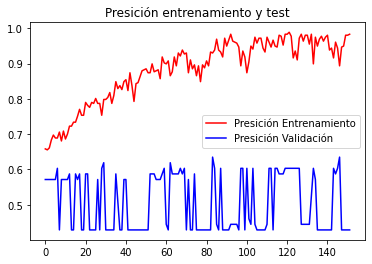

<Figure size 432x288 with 0 Axes>

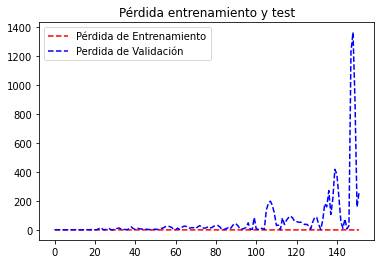

4/4 [==============================] - 1s 203ms/step - loss: 311.2092 - accuracy: 0.3113
Accuracy: 31.13
4/4 [==============================] - 1s 194ms/step


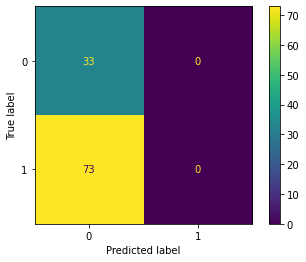

In [20]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,4,verbose=2)

loading [100%] file:/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/kic 9288786-K01390.01.pickle
normalizando datos...
dividiendo dataset...
before par:(528, 383) impar:(528, 383), labels:528
par:(106, 383, 1) impar:(106, 383, 1), labels:106
generando modelo....
entrenando...
Epoch 1/1000
6/6 - 67s - loss: 0.6637 - accuracy: 0.6508 - val_loss: 0.7114 - val_accuracy: 0.6250 - 67s/epoch - 11s/step
Epoch 2/1000
6/6 - 6s - loss: 0.6227 - accuracy: 0.6899 - val_loss: 0.8694 - val_accuracy: 0.6250 - 6s/epoch - 983ms/step
Epoch 3/1000
6/6 - 6s - loss: 0.6443 - accuracy: 0.6732 - val_loss: 0.6721 - val_accuracy: 0.6250 - 6s/epoch - 955ms/step
Epoch 4/1000
6/6 - 6s - loss: 0.6185 - accuracy: 0.6844 - val_loss: 0.6830 - val_accuracy: 0.6719 - 6s/epoch - 1s/step
Epoch 5/1000
6/6 - 6s - loss: 0.6308 - accuracy: 0.6732 - val_loss: 0.7768 - val_accuracy: 0.3750 - 6s/epoch - 975ms/step
Epoch 6/1000
6/6 - 6s - loss: 0.6170 - accuracy: 0.6899 - val_loss: 0.8086 - val_accuracy: 0.3750 - 6s/epoch -

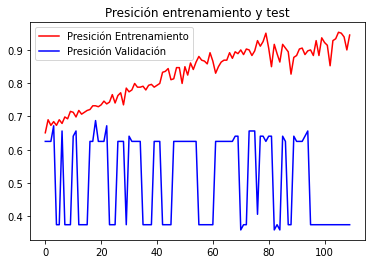

<Figure size 432x288 with 0 Axes>

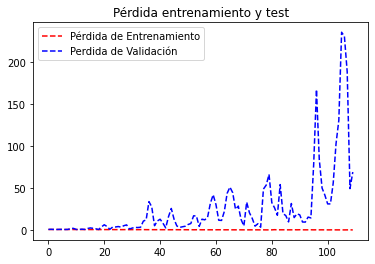

4/4 [==============================] - 1s 104ms/step - loss: 71.5108 - accuracy: 0.3396
Accuracy: 33.96
4/4 [==============================] - 1s 98ms/step


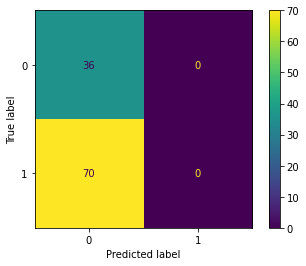

In [19]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,5,verbose=2)

In [ ]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,6,verbose=2)

In [ ]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,7,verbose=2)

loading [100%] file:/content/drive/MyDrive/MASTER IA (Unir)/TFM/waveletsK/kic 7283710-K04672.01.pickle
normalizando datos...
dividiendo dataset...
before par:(529, 55) impar:(529, 55), labels:529
par:(106, 55, 1) impar:(106, 55, 1), labels:106
generando modelo....
entrenando...
Epoch 1/1000
6/6 - 2s - loss: 0.6844 - accuracy: 0.6769 - val_loss: 0.6739 - val_accuracy: 0.5938 - 2s/epoch - 353ms/step
Epoch 2/1000
6/6 - 1s - loss: 0.6449 - accuracy: 0.7019 - val_loss: 0.7244 - val_accuracy: 0.5938 - 541ms/epoch - 90ms/step
Epoch 3/1000
6/6 - 1s - loss: 0.6278 - accuracy: 0.6964 - val_loss: 1.0703 - val_accuracy: 0.5938 - 520ms/epoch - 87ms/step
Epoch 4/1000
6/6 - 1s - loss: 0.6338 - accuracy: 0.6936 - val_loss: 1.1020 - val_accuracy: 0.5938 - 525ms/epoch - 88ms/step
Epoch 5/1000
6/6 - 1s - loss: 0.6128 - accuracy: 0.6964 - val_loss: 0.7642 - val_accuracy: 0.5938 - 520ms/epoch - 87ms/step
Epoch 6/1000
6/6 - 1s - loss: 0.6090 - accuracy: 0.6908 - val_loss: 0.6848 - val_accuracy: 0.6094 - 534

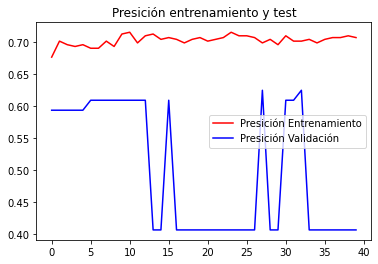

<Figure size 432x288 with 0 Axes>

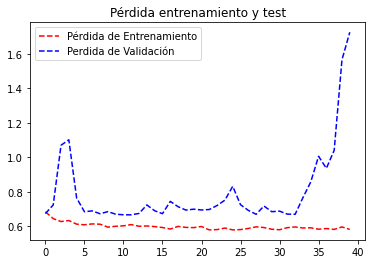

4/4 [==============================] - 0s 14ms/step - loss: 1.8060 - accuracy: 0.3774
Accuracy: 37.74
4/4 [==============================] - 0s 13ms/step


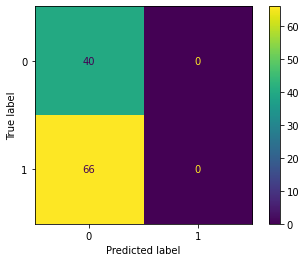

In [11]:
evaluate_model_1_level(gen_model_1_level_2,dataset_path,8,verbose=2)

## 2 niveles

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(526, 1507) impar:(526, 1507), labels:526
before par:(526, 758) impar:(526, 758), labels:526
test:2
test[0]:2,test[1]:2 
test[0][0]:106,test[0][1]:106 
test[1][0]:106,test[0][1]:106 
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 47s - loss: 0.6520 - accuracy: 0.7440 - binary_crossentropy: 0.6520 - val_loss: 1.1038 - val_accuracy: 0.4524 - val_binary_crossentropy: 1.1038 - 47s/epoch - 8s/step
Epoch 2/1000
6/6 - 39s - loss: 0.4739 - accuracy: 0.8542 - binary_crossentropy: 0.4739 - val_loss: 2.1004 - val_accuracy: 0.4524 - val_binary_crossentropy: 2.1004 - 39s/epoch - 7s/step
Epoch 3/1000
6/6 - 37s - loss: 0.4594 - accuracy: 0.8542 - binary_crossentropy: 0.4594 - val_loss: 2.7605 - val_accuracy: 0.5476 - val_binary_crossentropy: 2.7605 - 37s/epoch - 6s/step
Epoch 4/1000
6/6 - 37s - loss: 0.3976 - accuracy: 0.8601 - binary_crossentropy: 0.3976 - val_loss: 3.1828 - val_accuracy: 0.547

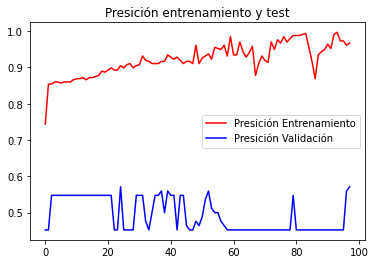

<Figure size 432x288 with 0 Axes>

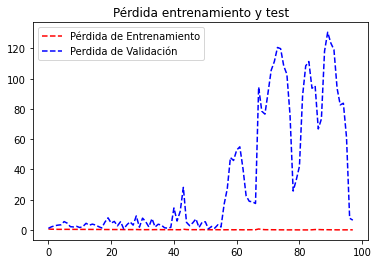

4/4 [==============================] - 3s 657ms/step - loss: 2.0464 - accuracy: 0.8585 - binary_crossentropy: 2.0464


ValueError: ignored

In [ ]:
evaluate_model(gen_model_2_levels,generate_dataset_model_2(dataset_path,levels=[3,4],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(526, 758) impar:(526, 758), labels:526
before par:(526, 383) impar:(526, 383), labels:526
test:2
test[0]:2,test[1]:2 
test[0][0]:106,test[0][1]:106 
test[1][0]:106,test[0][1]:106 
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 27s - loss: 0.6709 - accuracy: 0.7351 - binary_crossentropy: 0.6709 - val_loss: 0.7302 - val_accuracy: 0.4524 - val_binary_crossentropy: 0.7302 - 27s/epoch - 5s/step
Epoch 2/1000
6/6 - 18s - loss: 0.4930 - accuracy: 0.8631 - binary_crossentropy: 0.4930 - val_loss: 0.8018 - val_accuracy: 0.5476 - val_binary_crossentropy: 0.8018 - 18s/epoch - 3s/step
Epoch 3/1000
6/6 - 18s - loss: 0.4433 - accuracy: 0.8631 - binary_crossentropy: 0.4433 - val_loss: 1.4405 - val_accuracy: 0.5476 - val_binary_crossentropy: 1.4405 - 18s/epoch - 3s/step
Epoch 4/1000
6/6 - 19s - loss: 0.4154 - accuracy: 0.8631 - binary_crossentropy: 0.4154 - val_loss: 2.0191 - val_accuracy: 0.5476 

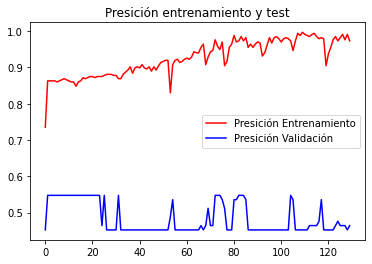

<Figure size 432x288 with 0 Axes>

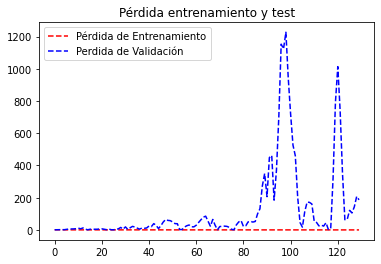

4/4 [==============================] - 1s 342ms/step - loss: 294.8486 - accuracy: 0.1321 - binary_crossentropy: 294.8486
[294.8486022949219, 0.1320754736661911, 294.8486022949219]


In [ ]:
evaluate_model(gen_model_2_levels,generate_dataset_model_2(dataset_path,levels=[4,5],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(528, 383) impar:(528, 383), labels:528
before par:(528, 195) impar:(528, 195), labels:528
test:2
test[0]:2,test[1]:2 
test[0][0]:106,test[0][1]:106 
test[1][0]:106,test[0][1]:106 
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 12s - loss: 0.6772 - accuracy: 0.7359 - binary_crossentropy: 0.6772 - val_loss: 0.7314 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.7314 - 12s/epoch - 2s/step
Epoch 2/1000
6/6 - 11s - loss: 0.5452 - accuracy: 0.8546 - binary_crossentropy: 0.5452 - val_loss: 1.0968 - val_accuracy: 0.4471 - val_binary_crossentropy: 1.0968 - 11s/epoch - 2s/step
Epoch 3/1000
6/6 - 9s - loss: 0.4278 - accuracy: 0.8516 - binary_crossentropy: 0.4278 - val_loss: 0.7567 - val_accuracy: 0.5529 - val_binary_crossentropy: 0.7567 - 9s/epoch - 2s/step
Epoch 4/1000
6/6 - 9s - loss: 0.4266 - accuracy: 0.8576 - binary_crossentropy: 0.4266 - val_loss: 1.8509 - val_accuracy: 0.5529 - v

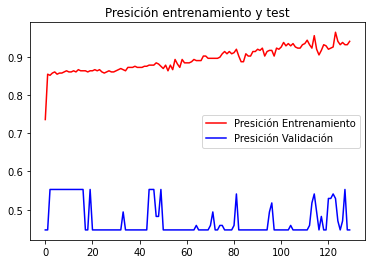

<Figure size 432x288 with 0 Axes>

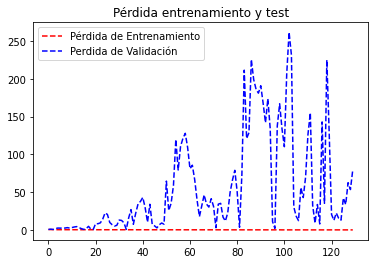

4/4 [==============================] - 1s 171ms/step - loss: 119.5820 - accuracy: 0.1415 - binary_crossentropy: 119.5820
[119.58200073242188, 0.14150942862033844, 119.58200073242188]


In [ ]:
evaluate_model(gen_model_2_levels,generate_dataset_model_2(dataset_path,levels=[5,6],show_loading=False),verbose=2)

In [ ]:
evaluate_model(gen_model_2_levels,generate_dataset_model_2(dataset_path,levels=[6,7],show_loading=False),verbose=2)

NameError: ignored

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(528, 102) impar:(528, 102), labels:528
before par:(528, 55) impar:(528, 55), labels:528
test:2
test[0]:2,test[1]:2 
test[0][0]:106,test[0][1]:106 
test[1][0]:106,test[0][1]:106 
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 5s - loss: 0.6860 - accuracy: 0.7151 - binary_crossentropy: 0.6860 - val_loss: 0.7160 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.7160 - 5s/epoch - 823ms/step
Epoch 2/1000
6/6 - 2s - loss: 0.6400 - accuracy: 0.8516 - binary_crossentropy: 0.6400 - val_loss: 0.8231 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.8231 - 2s/epoch - 315ms/step
Epoch 3/1000
6/6 - 2s - loss: 0.5278 - accuracy: 0.8516 - binary_crossentropy: 0.5278 - val_loss: 1.5689 - val_accuracy: 0.4471 - val_binary_crossentropy: 1.5689 - 2s/epoch - 326ms/step
Epoch 4/1000
6/6 - 2s - loss: 0.4173 - accuracy: 0.8487 - binary_crossentropy: 0.4173 - val_loss: 2.9454 - val_accuracy: 0.4471 

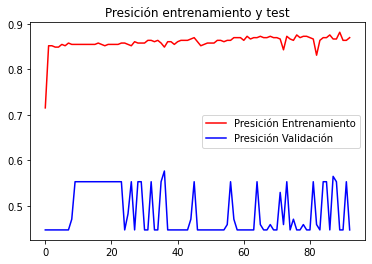

<Figure size 432x288 with 0 Axes>

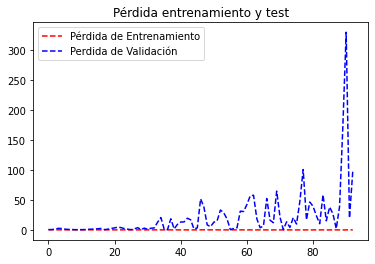

4/4 [==============================] - 0s 38ms/step - loss: 148.9187 - accuracy: 0.1415 - binary_crossentropy: 148.9187


ValueError: ignored

In [ ]:
evaluate_model(gen_model_2_levels,generate_dataset_model_2(dataset_path,levels=[7,8],show_loading=False),verbose=2)

## 3 niveles

In [ ]:
evaluate_model(gen_model_3_levels,generate_dataset_model_2(dataset_path,levels=[3,4,5],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(526, 1507) impar:(526, 1507), labels:526
before par:(526, 758) impar:(526, 758), labels:526
before par:(526, 383) impar:(526, 383), labels:526
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000


In [ ]:
evaluate_model(gen_model_3_levels,generate_dataset_model_2(dataset_path,levels=[4,5,6],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(528, 383) impar:(528, 383), labels:528
before par:(528, 195) impar:(528, 195), labels:528
before par:(528, 102) impar:(528, 102), labels:528
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 19s - loss: 0.6798 - accuracy: 0.8042 - binary_crossentropy: 0.6798 - val_loss: 0.7269 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.7269 - 19s/epoch - 3s/step
Epoch 2/1000
6/6 - 14s - loss: 0.5562 - accuracy: 0.8516 - binary_crossentropy: 0.5562 - val_loss: 1.2467 - val_accuracy: 0.4471 - val_binary_crossentropy: 1.2467 - 14s/epoch - 2s/step
Epoch 3/1000
6/6 - 14s - loss: 0.4217 - accuracy: 0.8516 - binary_crossentropy: 0.4217 - val_loss: 0.7179 - val_accuracy: 0.4588 - val_binary_crossentropy: 0.7179 - 14s/epoch - 2s/step
Epoch 4/1000
6/6 - 14s - loss: 0.4134 - accuracy: 0.8546 - binary_crossentropy: 0.4134 - val_loss: 0.8149 - val_accuracy: 0.5529 - val_binary_crossentropy: 0.8149 - 14s

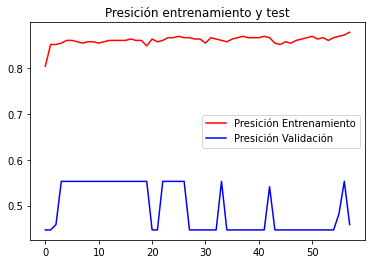

<Figure size 432x288 with 0 Axes>

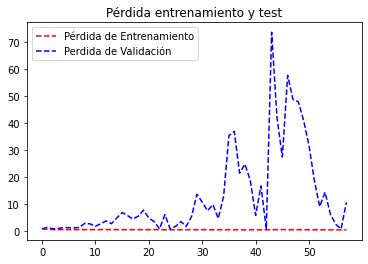

4/4 [==============================] - 1s 252ms/step - loss: 16.6510 - accuracy: 0.1509 - binary_crossentropy: 16.6510
[16.650955200195312, 0.15094339847564697, 16.650955200195312]


In [ ]:
evaluate_model(gen_model_3_levels,generate_dataset_model_2(dataset_path,levels=[5,6,7],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(528, 195) impar:(528, 195), labels:528
before par:(528, 102) impar:(528, 102), labels:528
before par:(528, 55) impar:(528, 55), labels:528
test:3
test[0]:2,test[1]:2 
test[0][0]:106,test[0][1]:106 
test[1][0]:106,test[0][1]:106 
generando modelo...
compilando modelo....
entrenando....
Epoch 1/1000
6/6 - 12s - loss: 0.6839 - accuracy: 0.7774 - binary_crossentropy: 0.6839 - val_loss: 0.7044 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.7044 - 12s/epoch - 2s/step
Epoch 2/1000
6/6 - 7s - loss: 0.6009 - accuracy: 0.8516 - binary_crossentropy: 0.6009 - val_loss: 0.9133 - val_accuracy: 0.4471 - val_binary_crossentropy: 0.9133 - 7s/epoch - 1s/step
Epoch 3/1000
6/6 - 7s - loss: 0.4426 - accuracy: 0.8516 - binary_crossentropy: 0.4426 - val_loss: 1.4490 - val_accuracy: 0.4471 - val_binary_crossentropy: 1.4490 - 7s/epoch - 1s/step
Epoch 4/1000
6/6 - 7s - loss: 0.4342 - accuracy: 0.8516 - binary_crossentropy: 0.434

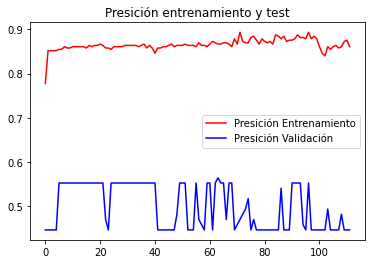

<Figure size 432x288 with 0 Axes>

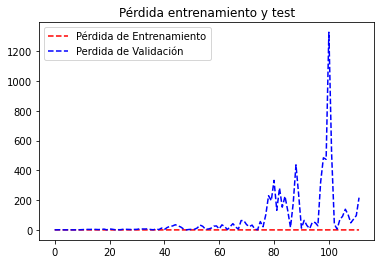

4/4 [==============================] - 1s 136ms/step - loss: 328.8416 - accuracy: 0.1321 - binary_crossentropy: 328.8416
[328.841552734375, 0.1320754736661911, 328.841552734375]


In [ ]:
evaluate_model(gen_model_3_levels,generate_dataset_model_2(dataset_path,levels=[6,7,8],show_loading=False),verbose=2)

## 4 niveles


normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(528, 383) impar:(528, 383), labels:528
before par:(528, 195) impar:(528, 195), labels:528
before par:(528, 102) impar:(528, 102), labels:528
before par:(528, 55) impar:(528, 55), labels:528
generando modelo...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv1d_80_input (InputLayer)   [(None, 383, 1)]     0           []                               
                                                                                                  
 conv1d_120_input (InputLayer)  [(None, 383, 1)]     0           []                               
                                                                                                  
 conv1d_80 (Conv1D)             (None, 379, 16)      96          ['conv1d_80_input[0][0]']        
 

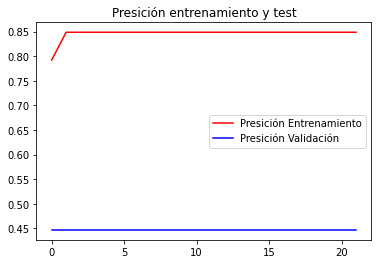

<Figure size 432x288 with 0 Axes>

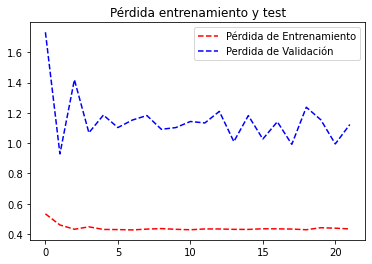

4/4 [==============================] - 4s 959ms/step - loss: 1.6667 - accuracy: 0.1321 - binary_crossentropy: 1.6667
[1.6667025089263916, 0.1320754736661911, 1.6667025089263916]


In [ ]:
evaluate_model(gen_model_4_levels,generate_dataset_model_2(dataset_path,levels=[5,6,7,8],show_loading=False),verbose=2)

In [ ]:
evaluate_model(gen_model_4_levels,generate_dataset_model_2(dataset_path,levels=[4,5,6,7],show_loading=False),verbose=2)

normalizando datos...
dividiendo datos en entrenamioento y test...
before par:(526, 758) impar:(526, 758), labels:526
before par:(526, 383) impar:(526, 383), labels:526
before par:(526, 195) impar:(526, 195), labels:526
before par:(526, 102) impar:(526, 102), labels:526
generando modelo...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv1d_input (InputLayer)      [(None, 758, 1)]     0           []                               
                                                                                                  
 conv1d_40_input (InputLayer)   [(None, 758, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 754, 16)      96          ['conv1d_input[0][0]']           
 

## Otros